In [5]:
# Import PyTorch library for tensor operations and deep learning
import torch

# Import torchvision's datasets and image transformations
from torchvision import datasets, transforms

# Import DataLoader for batch loading, TensorDataset for wrapping data
from torch.utils.data import DataLoader, TensorDataset

# Import neural network modules and optimizers from PyTorch
from torch import nn, optim

# Import PIL for image loading and manipulation
from PIL import Image

# Import NumPy for numerical operations (arrays, math, etc.)
import numpy as np

# Import os for interacting with the operating system (file paths, etc.)
import os

# Import matplotlib for plotting graphs and images
import matplotlib.pyplot as plt

# --- 1. Preprocessing and Transforms ---

# Define the preprocessing pipeline for the training data:
transform_train = transforms.Compose([
    transforms.RandomRotation(15),                    # Randomly rotate images up to 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.05)),  # Random shifts (10% width, 5% height)
    transforms.ToTensor(),                            # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))               # Normalize to [-1, 1] range
])

# Define the preprocessing pipeline for the testing/validation data:
transform_test = transforms.Compose([
    transforms.ToTensor(),                     # Convert images to PyTorch tensors (no random changes)
    transforms.Normalize((0.5,), (0.5,))        # Normalize tensor values the same way as training data
])


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define test transform (no random augmentations)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST training set with transformations
trainset = datasets.MNIST(
    root='./MNIST_data',
    train=True,
    download=True,
    transform=transform_train
)

# Create DataLoader for the training set
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)



In [7]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512), nn.ReLU(),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 64), nn.ReLU(),
    nn.Linear(64, 10)
)


In [8]:
import torch
import matplotlib.pyplot as plt

# Optional: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tracking
train_loss_history = []
val_acc_history = []

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10  # Change as needed
for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_loss_history.append(avg_loss)

    # --- Validation Step ---
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Val Accuracy: {val_acc:.2f}%")


Epoch 1/10 - Train Loss: 0.5933 - Val Accuracy: 94.00%
Epoch 2/10 - Train Loss: 0.2543 - Val Accuracy: 96.17%
Epoch 3/10 - Train Loss: 0.2035 - Val Accuracy: 97.53%
Epoch 4/10 - Train Loss: 0.1744 - Val Accuracy: 97.15%
Epoch 5/10 - Train Loss: 0.1562 - Val Accuracy: 97.31%
Epoch 6/10 - Train Loss: 0.1467 - Val Accuracy: 97.20%
Epoch 7/10 - Train Loss: 0.1380 - Val Accuracy: 97.93%
Epoch 8/10 - Train Loss: 0.1281 - Val Accuracy: 98.00%
Epoch 9/10 - Train Loss: 0.1258 - Val Accuracy: 97.69%
Epoch 10/10 - Train Loss: 0.1140 - Val Accuracy: 97.68%


In [9]:
# --- 7. Testing on MNIST Test Set ---

# Set the model to evaluation mode (disables dropout, etc.)
model.eval()

# Initialize counters for correct predictions and total samples
correct = 0
total = 0

# Turn off gradient calculations (makes testing faster and uses less memory)
with torch.no_grad():
    for images, labels in trainloader:         # Loop through the test data
        outputs = model(images)                # Forward pass: get model predictions
        _, predicted = torch.max(outputs, 1)   # Take the class with the highest score
        total += labels.size(0)                # Add the number of samples in this batch
        correct += (predicted == labels).sum().item()  # Count how many predictions were correct

# Calculate and print the final test set accuracy as a percentage
print(f"\nAccuracy on MNIST test set: {100 * correct / total:.2f}%")



Accuracy on MNIST test set: 96.11%


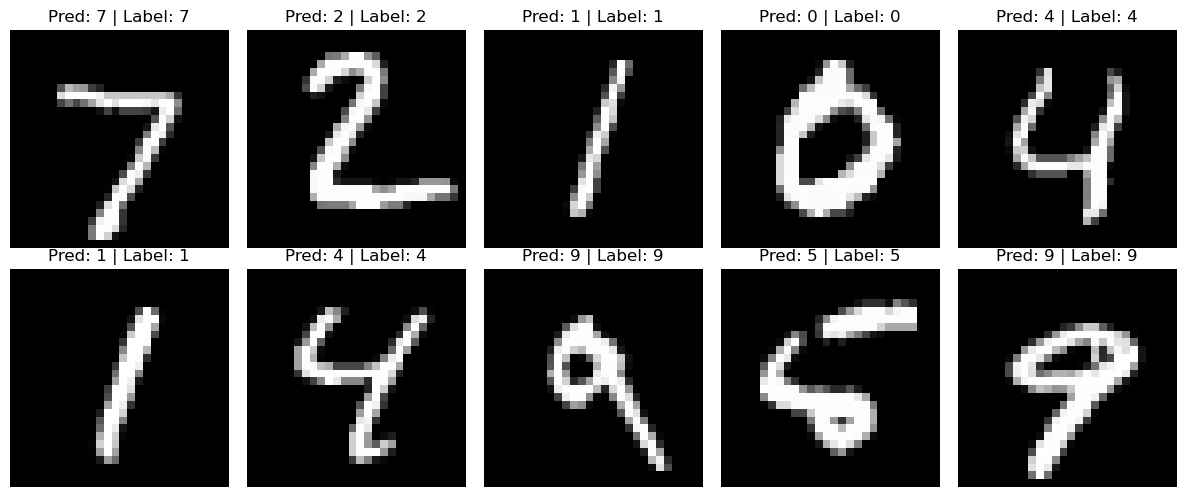

In [10]:
# --- 8. Visualize a Few Test Predictions ---

def show_mnist_predictions(model, testloader):
    model.eval()
    images, labels = next(iter(testloader))
    
    # If using GPU, move tensors to CPU before visualization
    images_cpu = images.cpu()
    labels_cpu = labels.cpu()
    outputs = model(images.to(next(model.parameters()).device))
    _, preds = torch.max(outputs, 1)

    # Create 2x5 grid of sample predictions
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images_cpu[i][0], cmap='gray')
        ax.set_title(f"Pred: {preds[i].item()} | Label: {labels_cpu[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to show predictions
show_mnist_predictions(model, testloader)


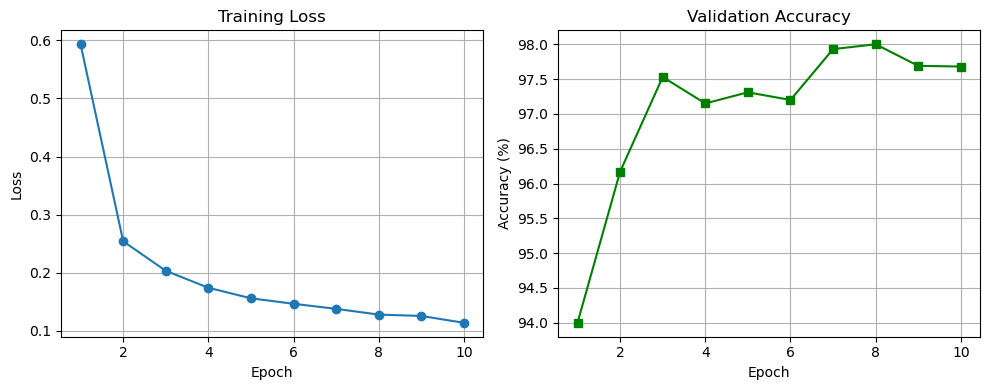

In [11]:
plt.figure(figsize=(10, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, marker='o', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_acc_history, marker='s', color='green', label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()
